In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sklearn
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
data_path = '/content/drive/My Drive/data88/'

In [0]:
ls '/content/drive/My Drive/data88'

ldavis_prepared_20       QC-ARC-Taxonomy.tsv
ldavis_prepared_20.html  QC-ARC-Taxonomy-visualization.pdf
QC-ARC-Questions.tsv


In [0]:
qc_questions = pd.read_csv(data_path + 'QC-ARC-Questions.tsv',delimiter='\t',encoding='utf-8')
qc_taxonomy = pd.read_csv(data_path + 'QC-ARC-Taxonomy.tsv', delimiter='\t', encoding='utf-8')

In [0]:
qc_questions.head()

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,grade,year,QCLabel,Question,subject,category,fold
0,Mercury_SC_405198,405198,1,D,1,0,Mercury,3,2015,LIFE_FUNCT_ENVCOND_PLANT,Which of these will most likely increase a pla...,NaN,Train,Challenge
1,Mercury_SC_415013,415013,1,B,1,0,Mercury,3,2015,"EARTH_INNER_INTHEAT, EARTH_INNER_PLATE_VOLC",Which rapid changes are caused by heat from in...,NaN,Train,Easy
2,Mercury_SC_405298,405298,1,C,1,0,Mercury,3,2015,OTHER,Which invention will best help people travel q...,NaN,Train,Easy
3,VASoL_2007_3_6,6,1,C,1,0,Virginia Standards of Learning - Science,3,2007,EARTH_HUMIMP_WHAT_HABITATDEST,A wetland habitat can continue to support the ...,NaN,Train,Challenge
4,Mercury_SC_416525,416525,1,A,1,0,Mercury,3,2015,LIFE_FUNCT_FEATANDFUNCT_PLANT_LEAF,Randall is picking lettuce from his garden for...,NaN,Train,Easy


In [0]:
qc_questions['QCLabel'].value_counts()

CEL_CYCLES                                                      146
MAT_CHEM_ATOMIC                                                 114
MAT_CHEM_PERIODICTAB                                            100
SCI_INFERENCE_EXPDESIGN                                          86
MAT_CHANGES_CHEMICAL                                             81
                                                               ... 
LIFE_FUNCT_ENVRESP_ANIM, LIFE_FUNCT_FEATANDFUNCT_ANIM_IMMUNE      1
LIFE_ENVADP_ADAP_ANIM_BEHAV_HIBER, LIFE_ENVADP_ADAP_PLANT         1
FOR_VELOCITY, FOR_MOMENTUM                                        1
EARTH_HUMIMP_RES_SOLAR, EARTH_HUMIMP_RES_HYDRO                    1
MAT_PROPO_MASS, MAT_PROPMATERIAL_DENSITY                          1
Name: QCLabel, Length: 1329, dtype: int64

In [0]:
qc_questions.shape[0]

7787

## Exploratory Data Analysis

For this stage, I will be trying out a variety of visualization techniques on the K12 QC ARC question banks based on their categories and the frequencies of similar questions across different subjects.

### Techniques to Include:
- WordCloud
- TF-IDF Vectorizer for Feature Extraction
- Clustering Using MiniBatch K-Means

### WordCloud

To perform a WordCloud visualization on the questions, we will be running all the questions through the following data pipeline:

- tokenization
- remove stop words
- tagging 
- keeping only nouns
- apply port stemmer and remove unit-length word

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def port_stem(s):
  p_stemmer = nltk.PorterStemmer()
  return [p_stemmer.stem(word) for word in s] 

In [0]:
tokenized_questions = qc_questions['Question'].str.lower().apply(nltk.word_tokenize)
tokenized_questions = tokenized_questions.apply(lambda tokens: [w for w in tokens if not w in stop_words])
tokenized_q_pos = tokenized_questions.apply(nltk.pos_tag)
tokenized_nouns = tokenized_q_pos.apply(lambda tags: [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')])
tokenized_nouns = tokenized_nouns.apply(port_stem).apply(lambda nouns: [noun for noun in nouns if len(noun) > 1])
retokenized = tokenized_nouns.apply(lambda tokens: ' '.join(tokens))

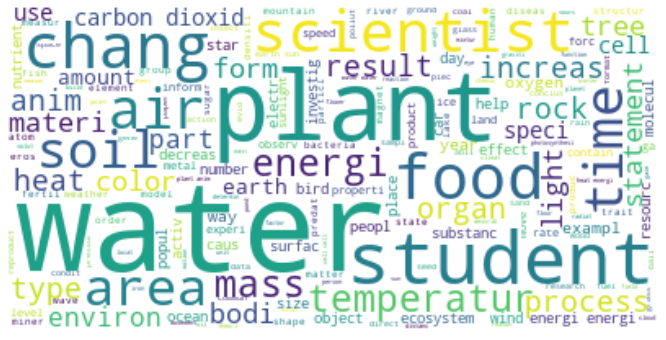

In [0]:
qtext = ''
for token in retokenized:
  qtext += token + ' '
wordcloud = WordCloud(background_color="white").generate(qtext)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

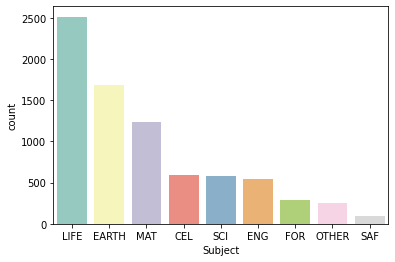

In [0]:
import seaborn as sns
sns.countplot(x='Subject', data=qc_questions, palette="Set3", order = qc_questions['Subject'].value_counts().index)

## TF-IDF Vectorization and MiniBatch K-Means

As an initial next step, to visualization how each exam question is phrased and the simillarity/difference among them across different subjects, we will compute the TF-IDF values as part of our feature extraction process and attempt to run an initial MiniBatch K-means clustering algorithm on the data.

As a first step, we will obtain the feature matrix on all the questions using the TfidfVectorizer.

In [0]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(qc_questions['Q_cleaned'].values)
features = vec.transform(qc_questions['Q_cleaned'].values)

In order to determine how many clusters we would like our K-means algorithm to aim for, we can start with a random guess and gradually increase the number of clusters.

In [0]:
cls_s = []
for i in range(5, 15):
  cls = MiniBatchKMeans(n_clusters=i, random_state=0)
  cls.fit(features)
  cls_s.append(cls)

In [0]:
for cls in cls_s:
  cls.predict(features)

To visualize, we’ll plot the features in a 3D space. As we know the dimension of features that we obtained from TfIdfVectorizer could be quite large, we need to reduce the dimension before we can plot. For this, we’ll ues PCA to transform our high dimensional features into 3 dimensions.

In [0]:
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features.toarray())
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

#### 5 Clusters

In [0]:
import plotly.graph_objects as go
fig = go.Figure(data=[
                      go.Scatter3d(x=reduced_features[:,0], y=reduced_features[:,1], z=reduced_features[:,2],
                                   mode='markers',text=qc_questions['Subject'], marker=dict(size=4,color=cls_s[0].predict(features),                
                                  colorscale='Rainbow',opacity=0.6)),
                      go.Scatter3d(x=reduced_cluster_centers[:,0], y=reduced_cluster_centers[:,1], z=reduced_cluster_centers[:,2],
                                   mode='markers',marker=dict(size=6, symbol='x', color='rgb(0, 0, 0)'))
                      ]
                )
fig.update_traces(textposition='top center')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

#### 10 Clusters

In [0]:
fig = go.Figure(data=[
                      go.Scatter3d(x=reduced_features[:,0], y=reduced_features[:,1], z=reduced_features[:,2],
                                   mode='markers',text=qc_questions['Subject'], marker=dict(size=4,color=cls_s[5].predict(features),                
                                  colorscale='Rainbow',opacity=0.6)),
                      go.Scatter3d(x=reduced_cluster_centers[:,0], y=reduced_cluster_centers[:,1], z=reduced_cluster_centers[:,2],
                                   mode='markers',marker=dict(size=6, symbol='x', color='rgb(0, 0, 0)'))
                      ]
                )
fig.update_traces(textposition='top center')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

#### 15 clusters

In [0]:
fig = go.Figure(data=[
                      go.Scatter3d(x=reduced_features[:,0], y=reduced_features[:,1], z=reduced_features[:,2],
                                   mode='markers', text=qc_questions['Subject'], marker=dict(size=4,color=cls_s[-1].predict(features),                
                                  colorscale='Rainbow',opacity=0.6)),
                      go.Scatter3d(x=reduced_cluster_centers[:,0], y=reduced_cluster_centers[:,1], z=reduced_cluster_centers[:,2],
                                   mode='markers',marker=dict(size=6, symbol='x', color='rgb(0, 0, 0)'))
                      ]
                )

fig.update_traces(textposition='top center')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

### LDA (Latent Dirichlet Allocation)

In [0]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(qc_questions['Question'])

def count_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 20
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

print("Topics found via LDA:")
count_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
soil coal resources oil natural use water resource used renewable

Topic #1:
energy light heat electrical sound chemical waves mechanical thermal solar

Topic #2:
water temperature evaporation high 10 ocean cold hot vapor ice

Topic #3:
student paper best volume property water mixture shape sample balance

Topic #4:
area theory likely change light species native new development habitat

Topic #5:
cell cells organism organ tissue dna membrane wall nucleus structure

Topic #6:
force ball mass object ice air gravity car speed friction

Topic #7:
moon earth cycle life egg adult light surface new phases

Topic #8:
increase decrease rate likely level number disease production h_ levels

Topic #9:
atom birds color protons electrons likely neutrons number bird parents

Topic #10:
body carbon dioxide oxygen systems human blood cells digestive nitrogen

Topic #11:
trees likely soil plant rain fish plants years forest tree

Topic #12:
graph line bar chart scientis

#### Visualizing the LDA Topic Modeling Results

In [0]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

CPU times: user 71.6 ms, sys: 3.87 ms, total: 75.4 ms
Wall time: 124 ms


In [0]:
LDAvis_data_filepath = os.path.join(data_path, 'ldavis_prepared_'+str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

In [0]:
pyLDAvis.save_html(LDAvis_prepared, data_path + '/ldavis_prepared_'+ str(number_topics) +'.html')

In [0]:
pyLDAvis.display(LDAvis_prepared)

### LSTM Modeling

In [0]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [0]:
MAX_WORD_COUNT = 5000
MAX_SEQ_SIZE = 50
EMBEDDING_DIM = 50
EPOCHS = 10
BATCH_SIZE = 32

In [0]:
category = qc_questions['QCLabel'].apply(lambda x: x.split('_')[0]).apply(lambda x: 'LIFE' if x == 'OTHER, LIFE' else x)
qc_questions['Subject'] = category

In [0]:

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [0]:
qc_questions['Q_cleaned'] = qc_questions['Question'].apply(clean_text).str.replace('\d+', '')

In [0]:
tokenizer = Tokenizer(num_words=MAX_WORD_COUNT, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(qc_questions['Q_cleaned'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10719 unique tokens.


In [0]:
X = tokenizer.texts_to_sequences(qc_questions['Q_cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQ_SIZE)
print('Shape of Design Matrix:', X.shape)

Shape of Design Matrix: (7787, 50)


In [0]:
y = pd.get_dummies(qc_questions['Subject']).values
print('Shape of Response Vector:', y.shape)

Shape of Response Vector: (7787, 9)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6618, 50) (6618, 9)
(1169, 50) (1169, 9)


In [0]:
model = Sequential()
model.add(Embedding(MAX_WORD_COUNT, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(50))
model.add(Dense(9, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 50)            250000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 459       
Total params: 270,659
Trainable params: 270,659
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5956 samples, validate on 662 samples
Epoch 1/10
5956/5956 [==============================] - 26s 4ms/step - loss: 2.3624 - accuracy: 0.5831 - val_loss: 1.9518 - val_accuracy: 0.7523
Epoch 2/10
5956/5956 [==============================] - 25s 4ms/step - loss: 1.5921 - accuracy: 0.7456 - val_loss: 2.3677 - val_accuracy: 0.2900
Epoch 3/10
5956/5956 [==============================] - 25s 4ms/step - loss: 1.1511 - accuracy: 0.6187 - val_loss: 1.2828 - val_accuracy: 0.7447
Epoch 4/10
5956/5956 [==============================] - 25s 4ms/step - loss: 0.6156 - accuracy: 0.8716 - val_loss: 1.5353 - val_accuracy: 0.7795
Epoch 5/10
5956/5956 [==============================] - 25s 4ms/step - loss: 0.4157 - accuracy: 0.9256 - val_loss: 2.0267 - val_accuracy: 0.7855
Epoch 6/10
5956/5956 [==============================] - 25s 4ms/step - loss: 0.3279 - accuracy: 0.9466 - val_loss: 2.1312 - val_accuracy: 0.7779
Epoch 7/10
5956/5956 [==============================] - 25s 4ms/step - loss: 0.6632

In [0]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1169/1169 [==============================] - 0s 334us/step
Test set
  Loss: 2.287
  Accuracy: 0.759


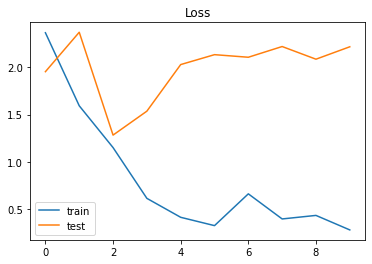

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

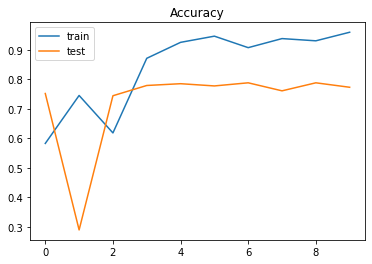

In [0]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();